In [74]:
from importlib.metadata import version

pkgs = ["matplotlib",  # Plotting library
        "numpy",       # PyTorch & TensorFlow dependency
        "tiktoken",    # Tokenizer
        "torch",       # Deep learning library
        "tensorflow",  # For OpenAI's pretrained weights
        "pandas"       # Dataset loading
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.0
numpy version: 2.0.2
tiktoken version: 0.12.0
torch version: 2.9.0+cu126
tensorflow version: 2.19.0
pandas version: 2.2.2


## Fine-Tuning

The most common ways to fine-tune a language models are :

* Classification Fine-Tuning
* Instruction Fine-Tuning



## 1.Preparing the Dataset

In [75]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [76]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [77]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


We notice that the data contains "ham" (i.e., "not spam") much more frequently than "spam".

So, what we are going to do now is create a balanced dataset so that both the instances of Label have the same amount of data.

Basically, we are going to subsample it.


In [78]:
def create_balanced_dataset(df):

    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]

    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    # .sample(num_spam) will randomly pick the same number of ham rows as spam.
    # random_state is to produce the same pick no matter how much we run it.

    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df


balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [79]:
balanced_df.head()

,Label,Text
4307,ham,Awww dat is sweet! We can think of something t...
4138,ham,Just got to &lt;#&gt;
4831,ham,"The word ""Checkmate"" in chess comes from the P..."
4461,ham,This is wishing you a great day. Moji told me ...
5440,ham,Thank you. do you generally date the brothas?


In [80]:
# changing the labels to integer

balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [81]:
balanced_df.head()

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?


## Splitting the data into Training Set, Validation Set and Testing Set

In [82]:
# 100 : 1-70 for training, 70-90 for validation and 90-100 for testing

def random_split(df, train_frac, validation_frac): # passing in how we want to divide the data

    df = df.sample(frac = 1, random_state = 123).reset_index(drop = True)
    # frac = 1 means we will shuffle all the rows randomly
    # reset_index(drop=True) → resets row numbers to 0,1,2,… after shuffling


  # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)
    print(f"Train End : {train_end}")
    print(f"Validation End : {validation_end}")

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder

Train End : 1045
Validation End : 1194


In [83]:
# Let’s save the dataset as CSV (comma-separated value) files so we can reuse it later

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## Creating DataLoaders

The text messages have different lengths; if we want to combine multiple training examples in a batch, we have to either :

* Truncate all messages to the length of the shortest message in the dataset or batch

* Pad all messages to the length of the longest message in the dataset or batch.

We choose option 2 and pad all messages to the longest message in the dataset.

For that, we use <|endoftext|> as a padding token.

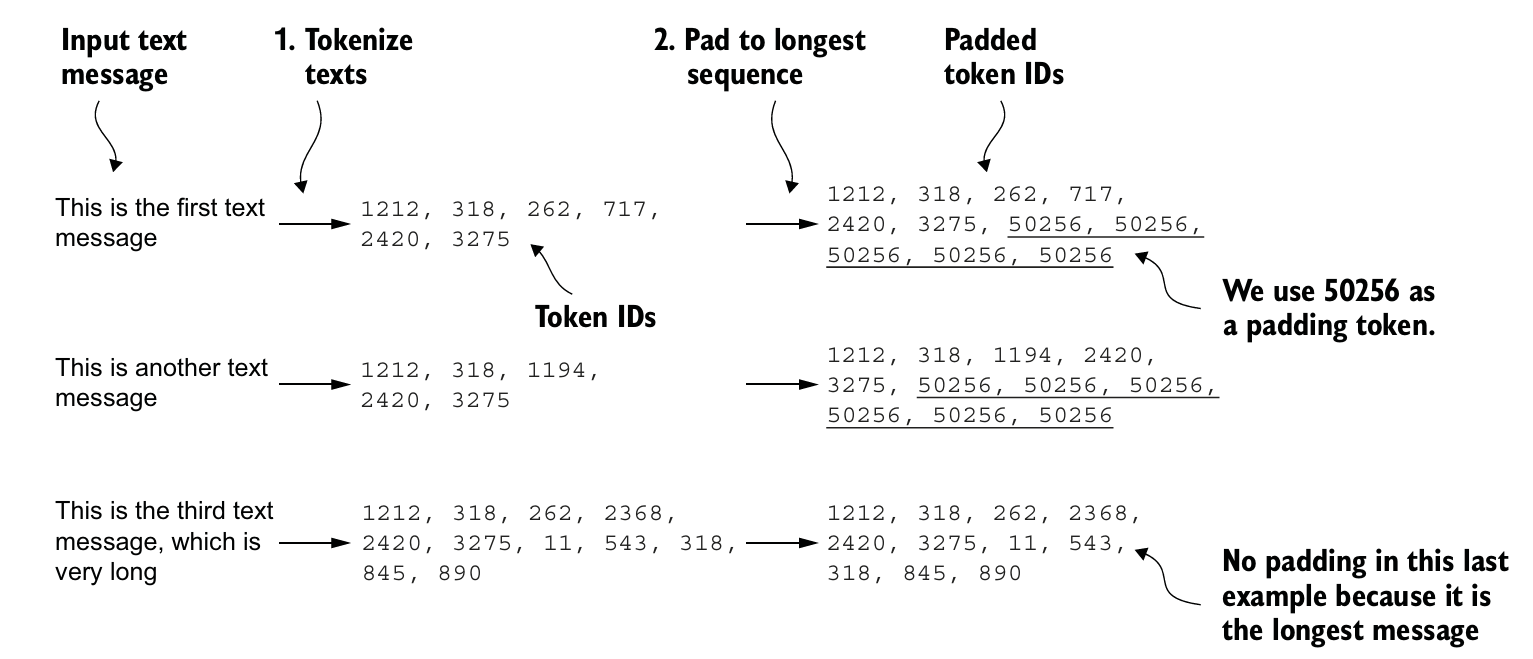

In [84]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("Hello <|endoftext|>", allowed_special={"<|endoftext|>"}))

[15496, 220, 50256]


In [85]:
tokenizer.decode([50256])

'<|endoftext|>'

We can see that the token for <|endoftext|> is 50256.

Normally, we do this in a batch basis but right now, for simplicity, we will take the entire dataset.

We first need to implement a PyTorch Dataset, which specifies how the data is
loaded and processed before we can instantiate the data loaders. For this purpose,
we define the SpamDataset class.

This
SpamDataset class handles several key tasks:

* It identifies the longest sequence in the
training dataset, encodes the text messages, and ensures that all other sequences are padded with a padding token to match the length of the longest sequence

In [86]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index] # choosing which row we want
        label = self.data.iloc[index]["Label"] # returns the label for that row (0/1 meaning ham or spam)
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long))
        # will return a tuple of tensor i.e. encoded texts and label
        # ([15496, 314, 50256], 1)

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
      return max(len(encoded_text) for encoded_text in self.encoded_texts)

In [87]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


In [88]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

Next, we use the dataset to instantiate the data loaders.

In [89]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [90]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [91]:
next(iter(train_loader))

[tensor([[ 4805,  3824,  6158,     0,  3406,  5816, 10781, 21983,   329,   657,
           3695, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
         [   39,  2394, 28323, 29250,  

In [92]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## Initializing a model with pretrained weights

In [93]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [94]:
!pip install tensorflow tqdm

In [95]:
from gpt_download import download_and_load_gpt2
from gpt_from_scratch_to_generate_texts import GPTModel
from pre_training_with_unlabeled_data import load_weights_into_gpt


model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [96]:
from gpt_from_scratch_to_generate_texts import generate_text_simple
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension since our model
    # expects inputs to be in batch
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist()) # .tolist() converts tensor to a python list


text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [97]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


## Adding a Classification Head

We must modify the pretrained LLM to prepare it for classification fine-tuning.

To do
so, we replace the original output layer, which maps the hidden representation to a
vocabulary of 50,257, with a smaller output layer that maps to two classes: 0 (“not
spam”) and 1 (“spam”). We use the same model as before, except
we replace the output layer.



In [98]:
# Let's print the model architecture first.
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNormalization()
      (norm2): LayerNormalization()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Li

The goal is to replace and finetune the output layer :  (out_head): Linear(in_features=768, out_features=50257, bias=False)

## Fine-Tuning Results on Different Layers

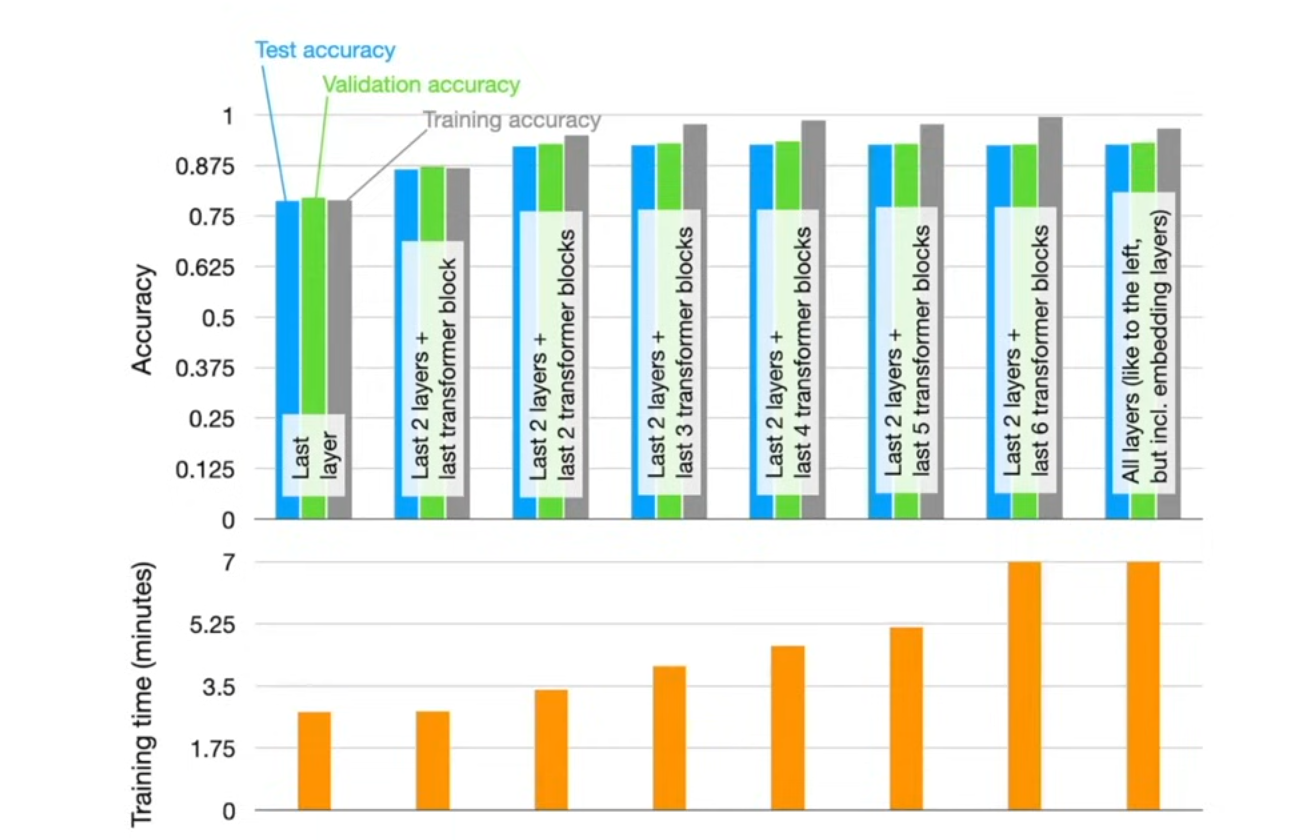

We have already pre-trained our model.

Since spam-classification is a simple problem, it's not necessary that we fine-tune all of the layers. This might lead to overfitting and time-consumption.

So, we can actually train just the last few layers.


## Step 1 : Freeze the Model : Make the layers non-trainable



In [99]:
for param in model.parameters(): # parameters are the weights (and biases) values
  pass

print(param.requires_grad)

True


In [100]:
# We can see that the requires_grad is True initially meaning their gradients
# will be calculated and they will be trained through backprop.

# So we will set it to false basically making all of them untrainable.

for param in model.parameters():
  param.requires_grad = False

print(param.requires_grad)

False


In [101]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)
print(model.out_head)

Linear(in_features=768, out_features=2, bias=True)


This new model.out_head output layer has its requires_grad attribute set to
True by default, which means that it’s the only layer in the model that will be
updated during training.

However, training other few layers can give us an increase in performance and accuracy.


So, we are also making the last transformer block and the final LayerNorm module connecting the last transformer block to the output layer trainable.

Our trainable Layers :     



```
 (11): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNormalization()
      (norm2): LayerNormalization()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
  )
  (final_norm): LayerNormalization()
  (out_head): Linear(in_features=768, out_features=50257, bias=False)
)
```



In [102]:
for param in model.trf_blocks[-1].parameters(): # last transformer block
    param.requires_grad = True

for param in model.final_norm.parameters(): # final normalization block
    param.requires_grad = True

In [103]:
inputs = tokenizer.encode("Do you wanna work together?")
inputs = torch.tensor(inputs).unsqueeze(0) # adding dim bc our model expects inputs in batches
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[ 5211,   345, 18869,   670,  1978,    30]])
Inputs dimensions: torch.Size([1, 6])


In [104]:
with torch.no_grad():
  outputs = model(inputs)

outputs, outputs.shape

(tensor([[[-1.5857,  0.9902],
          [-3.7264,  7.4538],
          [-3.3508,  7.0202],
          [-3.2775,  6.0175],
          [-3.7323,  5.0449],
          [-4.9916,  6.4437]]]),
 torch.Size([1, 6, 2]))

A similar input would have previously produced an output tensor of [1, 6, 50257],
where 50257 represents the vocabulary size. The number of output rows corresponds
to the number of input tokens (in this case, four).

However, each output’s embedding
dimension (the number of columns) is now 2 instead of 50,257 since we replaced the
output layer of the model.

We are interested in fine-tuning this model to return a class label
indicating whether a model input is “spam” or “not spam.” We don’t need to fine
tune all four output rows; instead, we can focus on a single output token.

 In particular, we will focus on the last row corresponding to the last output token.

In [105]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-4.9916,  6.4437]])


## Calculating the classification loss and accuracy

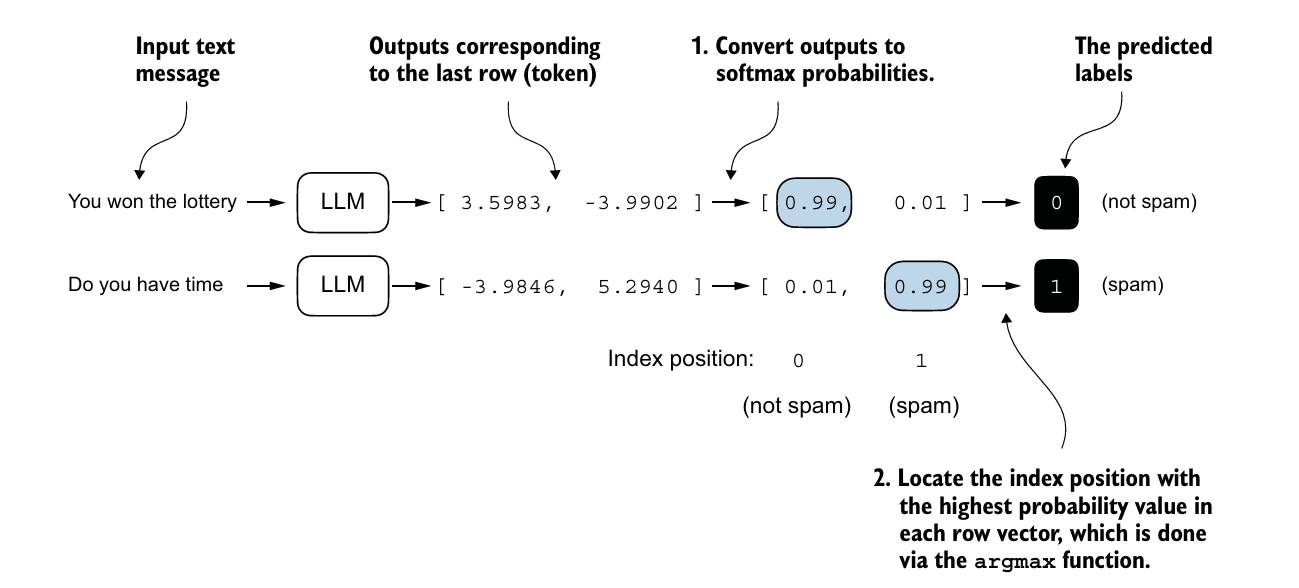

In [106]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


We got 1 meaning it predicted it as a spam text.

In [107]:
# the softmax function is optional here because the largest outputs
# correspond to the largest probability scoreslogits = outputs[:, -1, :]
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


In [108]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [109]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

cuda
Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


### Calculating loss with Cross-Entropy

In [110]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [111]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [112]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.451
Validation loss: 2.581
Test loss: 2.320


## Finetuning the model on supervised data

In [113]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0]
            # We do this because each batches contain many examples so incrementing it by 1 would be wrong.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [114]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.151, Val loss 2.391
Ep 1 (Step 000050): Train loss 0.613, Val loss 0.634
Ep 1 (Step 000100): Train loss 0.524, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.562, Val loss 0.492
Ep 2 (Step 000200): Train loss 0.421, Val loss 0.402
Ep 2 (Step 000250): Train loss 0.386, Val loss 0.325
Training accuracy: 82.50% | Validation accuracy: 87.50%
Ep 3 (Step 000300): Train loss 0.225, Val loss 0.175
Ep 3 (Step 000350): Train loss 0.216, Val loss 0.092
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 4 (Step 000400): Train loss 0.043, Val loss 0.086
Ep 4 (Step 000450): Train loss 0.101, Val loss 0.067
Ep 4 (Step 000500): Train loss 0.172, Val loss 0.074
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.180, Val loss 0.082
Ep 5 (Step 000600): Train loss 0.060, Val loss 0.047
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 0.95 min

In [115]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

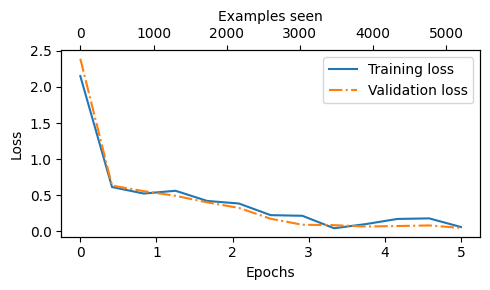

In [116]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

## Accuracy Plot

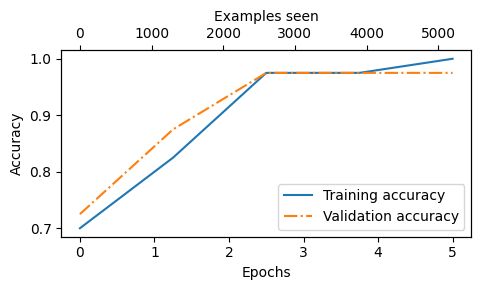

In [117]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [118]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.98%
Validation accuracy: 97.99%
Test accuracy: 96.67%


## Using the LLM as an Spam Classifier

We will try the model on new data meaning new text messages to see how well it will do.

In [132]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
  # remember that max length refers to the sequence length that the model will accept
  # if not enough, padding will be added
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]


    max_len = min(max_length,supported_context_length) if max_length else supported_context_length
    input_ids = input_ids[:max_len]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [126]:
text = "Do you wanna hang out next week?" # Pass in only one text
result = classify_review(text, model = model, tokenizer = tokenizer, device = device, max_length=train_dataset.max_length )
print(result)

not spam


In [127]:
text2 = "Do you wanna claim your prize?" # Pass in only one text
result = classify_review(text, model = model, tokenizer = tokenizer, device = device, max_length=train_dataset.max_length )
print(result)

not spam


In [128]:
text3 = "claim your prize" # Pass in only one text
result = classify_review(text, model = model, tokenizer = tokenizer, device = device, max_length=train_dataset.max_length )
print(result)

not spam


In [129]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [130]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


We can save the model so that we can reuse it later without having to train it again.

In [131]:
torch.save(model.state_dict(), "review_classifier.pth")

In a new session, we can load it like this :



```
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)
```

